# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"><img src="../images/icon102.png" width="38px"></img> **Hopsworks Feature Store** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Model Training</span>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/logicalclocks/hopsworks-tutorials/blob/master/bitcoin/4_model_training.ipynb)

## 🗒️ In this notebook you will see how to create and deploy a model using  Hopsworks Feature Store : 

1. Loading the training data.
2. Train the model.
3. Register model in Hopsworks model registry.
4. Online model deployment.
5. Using the deployment to make a prediciton.

![part3](../images/03_model.png) 

## <span style="color:#ff5f27;"> 📡 Connecting to Hopsworks Feature Store </span>

In [1]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/167
Connected. Call `.close()` to terminate connection gracefully.


---
### <span style="color:#ff5f27;"> 📝 Imports</span>

In [2]:
from __future__ import print_function

import tensorflow as tf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

%config InlineBackend.figure_format='retina'
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', quality=100)

import warnings
warnings.filterwarnings('ignore')

2022-09-29 11:52:11.734716: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


---

## <span style="color:#ff5f27;">🪝 Feature View and Training Dataset Retrieval</span>

In [3]:
feature_view = fs.get_feature_view(
    name = 'bitcoin_feature_view',
    version = 1
)

In [4]:
train_x, _ = feature_view.get_training_data(1)
val_x, _ = feature_view.get_training_data(2)
test_x, _ = feature_view.get_training_data(3)

In [12]:
train_y = train_x[["close"]]
val_y = val_x[["close"]]
test_y = test_x[["close"]]

---

## <span style="color:#ff5f27;">🤖 Time series model</span>

In [13]:
# Now lets define Tensorflow Dataset as we are going to train keras tensorflow model

def windowed_dataset(dataset, target, window_size, batch_size):
    ds = dataset.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(window_size))
    ds = ds.map(lambda window: tf.reshape(window[-1:], [-1, 34]))
        
    target_ds = target.window(window_size, shift=1, drop_remainder=True)
    target_ds = target_ds.flat_map(lambda window: window.batch(window_size))
    target_ds = target_ds.map(lambda window: window[-1:])
    
    ds = tf.data.Dataset.zip((ds, target_ds))
    ds = ds.batch(batch_size,True)
    ds = ds.prefetch(1)
    return ds

In [14]:
training_dataset = tf.data.Dataset.from_tensor_slices(tf.cast(train_x.values, tf.float32)) 
training_target = tf.data.Dataset.from_tensor_slices(train_y.values.flatten().tolist()) 
training_dataset = training_dataset.repeat(500)
training_dataset = windowed_dataset(training_dataset, training_target, window_size=2, batch_size=16)
training_dataset

2022-09-29 12:31:19.405892: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<PrefetchDataset element_spec=(TensorSpec(shape=(16, None, 34), dtype=tf.float32, name=None), TensorSpec(shape=(16, None), dtype=tf.float32, name=None))>

In [15]:
validation_dataset = tf.data.Dataset.from_tensor_slices(tf.cast(val_x.values, tf.float32))
validation_target = tf.data.Dataset.from_tensor_slices(val_y.values.flatten().tolist()) 
training_dataset = training_dataset.repeat(500)
validation_dataset = windowed_dataset(validation_dataset, validation_target, window_size=2, batch_size=16)
validation_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(16, None, 34), dtype=tf.float32, name=None), TensorSpec(shape=(16, None), dtype=tf.float32, name=None))>

In [16]:
test_dataset = tf.data.Dataset.from_tensor_slices(tf.cast(test_x.values, tf.float32))
test_target = tf.data.Dataset.from_tensor_slices(test_y.values.flatten().tolist()) 
test_dataset = windowed_dataset(test_dataset, test_target, window_size=2, batch_size=1)
test_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(1, None, 34), dtype=tf.float32, name=None), TensorSpec(shape=(1, None), dtype=tf.float32, name=None))>

In [17]:
def build_model(input_dim):
    inputs = tf.keras.layers.Input(shape=(input_dim[0],input_dim[1]))
    x = tf.keras.layers.Conv1D(filters = 128, kernel_size=1, padding='same', kernel_initializer="uniform")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)    
    x = tf.keras.layers.MaxPooling1D(pool_size=2, padding='same')(x)
    x = tf.keras.layers.Conv1D(filters = input_dim[1], kernel_size= 1,padding='same',  kernel_initializer="uniform")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)    
    x = tf.keras.layers.MaxPooling1D(pool_size=2, padding='same')(x)    

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(34, activation="relu", kernel_initializer="uniform")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1, activation="relu", kernel_initializer="uniform")(x)
    
    model = tf.keras.Model(inputs, x)
    model.summary()
    model.compile(loss='mse',optimizer='adam',metrics=['mae'])
    return model

In [18]:
model = build_model([1, 34])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 34)]           0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4480      
                                                                 
 batch_normalization (BatchN  (None, 1, 128)           512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1, 128)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 128)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 34)             4386  

In [19]:
from timeit import default_timer as timer
start = timer()
history = model.fit(training_dataset,
                    epochs=100,
                    verbose=0,
                    steps_per_epoch=500,
                    validation_data=validation_dataset,
                    validation_steps=1,                    
                   )
end = timer()
print(end - start)

2022-09-29 12:31:42,739 WARNING: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 50000 batches). You may need to use the repeat() function when building your dataset.
20.230335147999995


In [20]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

### <span style='color:#ff5f27'>👮🏻‍♂️ Model Validation</span>

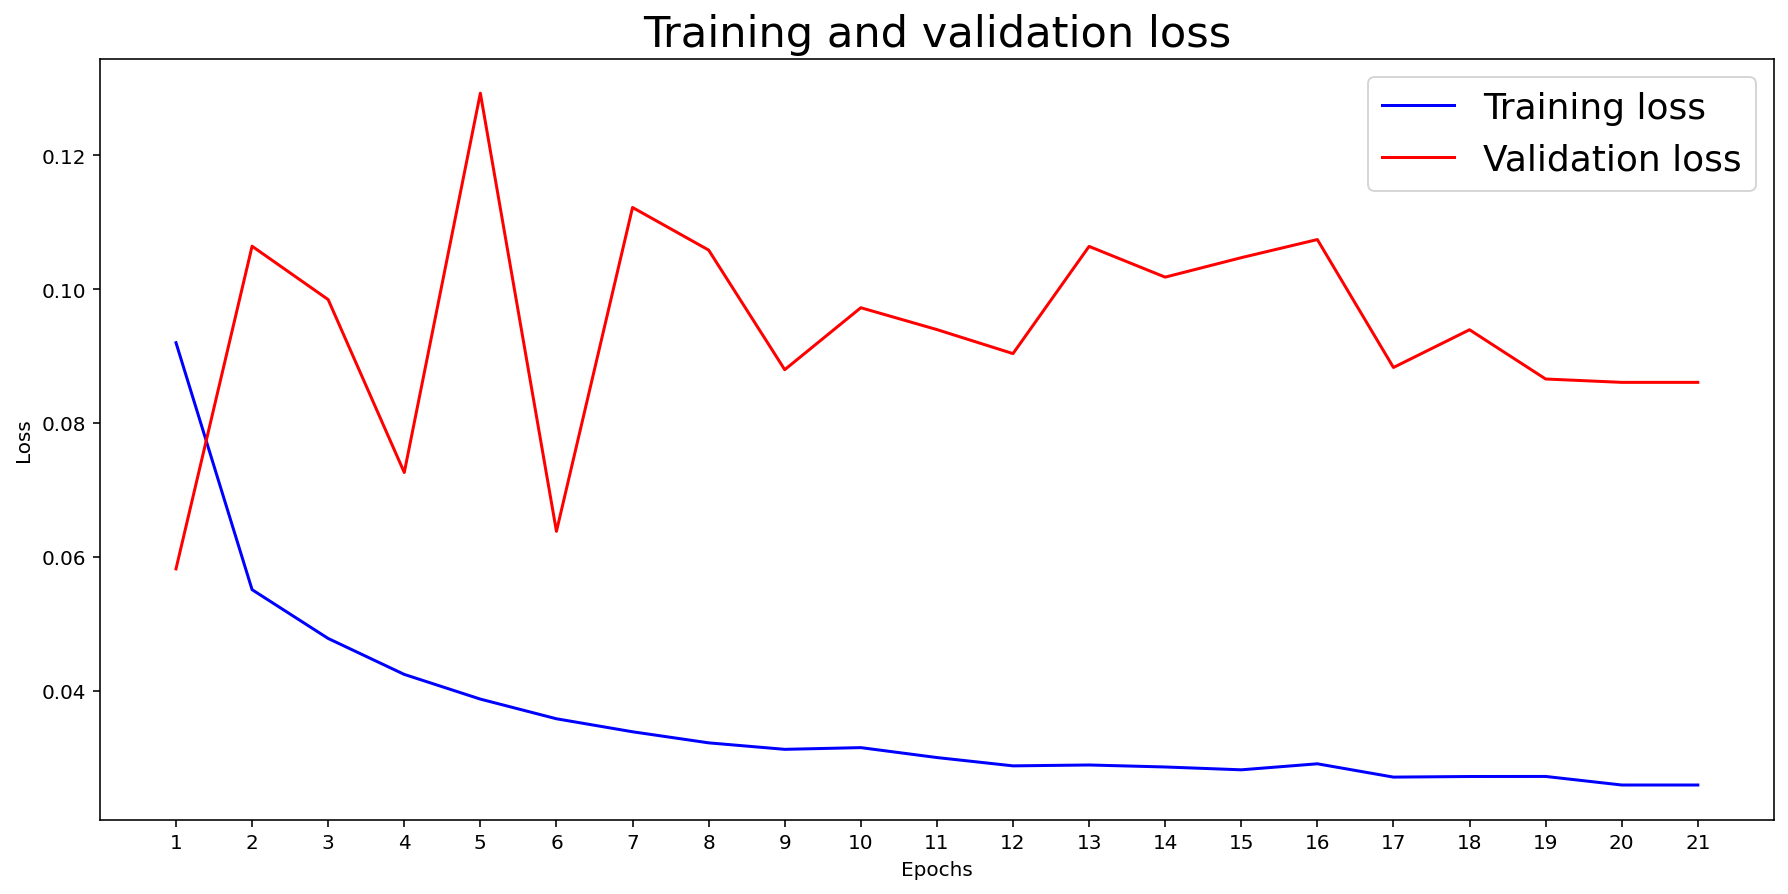

In [21]:
loss_values = history_dict['mae']
val_loss_values = history_dict['val_mae']

loss_values50 = loss_values
val_loss_values50 = val_loss_values
epochs = range(1, len(loss_values50) + 1)
plt.plot(epochs, loss_values50, 'b',color = 'blue', label='Training loss')
plt.plot(epochs, val_loss_values50, 'b',color='red', label='Validation loss')
plt.rc('font', size = 18)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(15,7)
plt.show()

In [22]:
prediction_close = model.predict(test_x.values.reshape(-1, 1, 34))
prediction_close[:5]

2/2 [==============================] - 0s 3ms/step


array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]], dtype=float32)

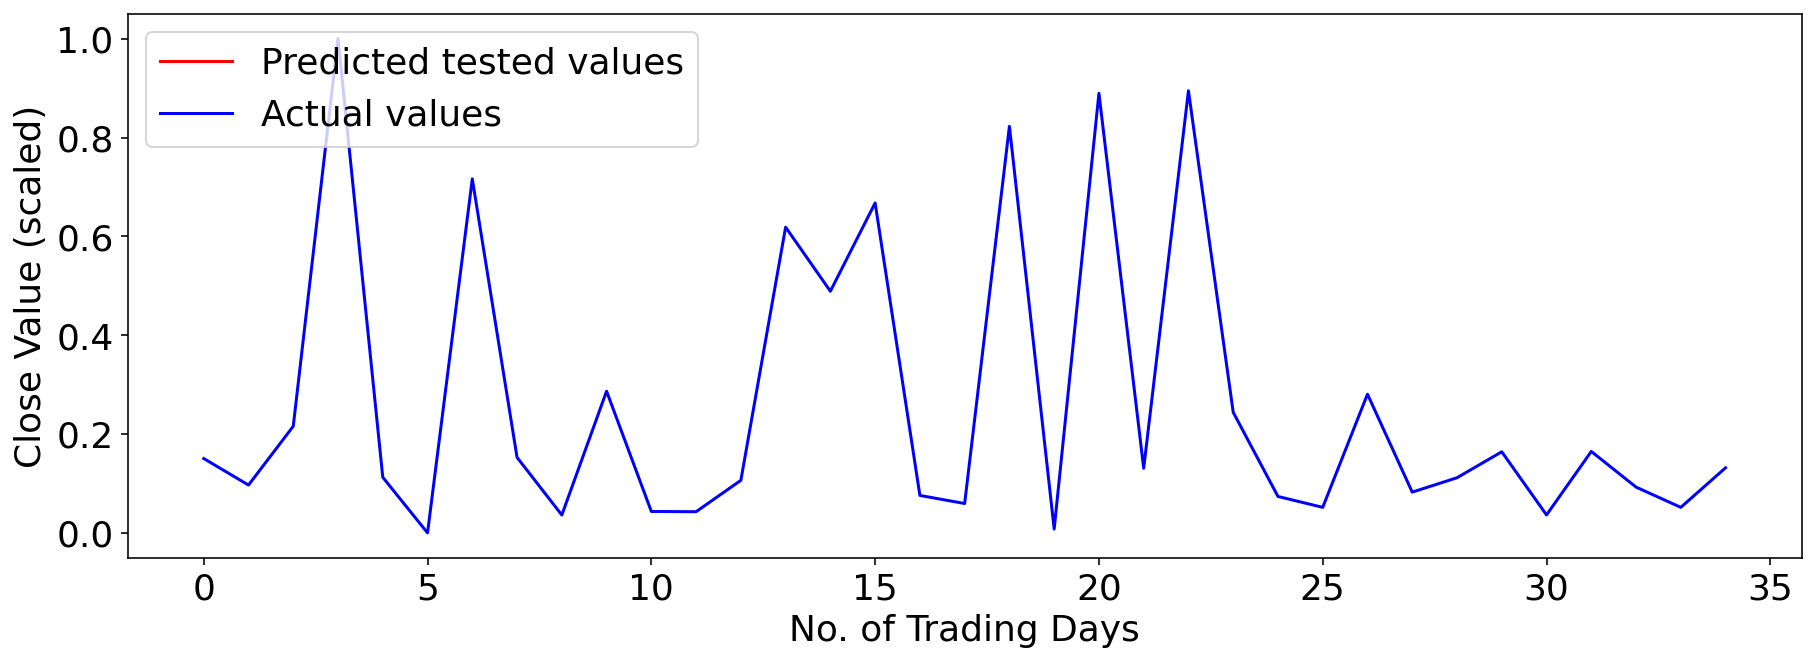

In [23]:
plt.plot(prediction_close,color='red', label='Predicted tested values')
plt.plot(test_y.values, color='blue', label='Actual values')
plt.xlabel('No. of Trading Days')
plt.ylabel('Close Value (scaled)')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()

In [24]:
from sklearn.metrics import accuracy_score
from sklearn import metrics

metrics.mean_absolute_error(test_y, prediction_close)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
colors = ['darkslategrey']

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

ax.plot(test_y, 'black')
ax.plot(prediction_close, 'yellow')
ax.set_ylabel('$price$')
ax.set_xlabel('$time$')
ax.grid(True)
ax.legend(["actual", "pred"])

fig.tight_layout()

plt.grid(True)
plt.show()

In [ ]:
import inspect 
# Recall that you applied transformation functions, such as min max scaler and laber encoder. 
# Now you want to transform them back to human readable format.
feature_view.init_serving(1)
td_transformation_functions = feature_view._single_vector_server._transformation_functions

pred_y = pd.DataFrame(prediction_close, columns=["close"])

for feature_name in td_transformation_functions:
    if feature_name == "close":
        td_transformation_function = td_transformation_functions[feature_name]
        sig, foobar_locals = inspect.signature(td_transformation_function.transformation_fn), locals()
        param_dict = dict([(param.name, param.default) for param in sig.parameters.values() if param.default != inspect._empty])
        if td_transformation_function.name == "min_max_scaler":
            pred_y[feature_name] = pred_y[feature_name].map(lambda x: x*(param_dict["max_value"]-param_dict["min_value"])+param_dict["min_value"])
            test_y[feature_name] = test_y[feature_name].map(lambda x: x*(param_dict["max_value"]-param_dict["min_value"])+param_dict["min_value"])

In [ ]:
colors = ['darkslategrey']

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

ax.plot(test_y, 'black')
ax.plot(pred_y, 'yellow')
ax.set_ylabel('$price$')
ax.set_xlabel('$time$')
ax.grid(True)
ax.legend(["actual", "pred"])

fig.tight_layout()

plt.grid(True)
plt.show()

---
## <span style='color:#ff5f27'>🗄 Model Registry</span>

In [ ]:
export_path = "bitcoin_price_model"
print('Exporting trained model to: {}'.format(export_path))
    
tf.saved_model.save(model, export_path) 

In [ ]:
mr = project.get_model_registry()
metrics={'loss': history_dict['val_mae'][0]} 

mr_model = mr.tensorflow.create_model(
    name="bitcoin_price_model",
    metrics=metrics,
    description="bitcoin daily price detection model.",
    input_example=["1615240800000"]
)

In [ ]:
mr_model.save(export_path)

---
## <span style="color:#ff5f27;">🚀 Model Deployment</span>

In [ ]:
%%writefile btc_model_transformer.py

import os
import hsfs
import numpy as np

class Transformer(object):
    
    def __init__(self):        
        # get feature store handle
        fs_conn = hsfs.connection()
        self.fs = fs_conn.get_feature_store()
        
        # get feature views
        self.fv = self.fs.get_feature_view("bitcoin_feature_view", 1)
        
        # initialise serving
        self.fv.init_serving(1)

    def flat2gen(self, alist):
        for item in alist:
            if isinstance(item, list):
                for subitem in item: yield subitem
            else:
                yield item
        
    def preprocess(self, inputs):
        feature_vector = self.fv.get_feature_vector({"unix": inputs["inputs"][0]})
        return { "inputs" :  np.array(list(self.flat2gen(feature_vector))).reshape(-1, 1, 34).tolist() }

    def postprocess(self, outputs):
        return outputs    

In [ ]:
import os
from hsml.transformer import Transformer
dataset_api = project.get_dataset_api()

uploaded_file_path = dataset_api.upload("btc_model_transformer.py", "Models", overwrite=True)
transformer_script_path = os.path.join("/Projects", project.name, uploaded_file_path)
transformer_script = Transformer(script_file=transformer_script_path)

In [ ]:
# Use the model name from the previous notebook.
model = mr.get_model("bitcoin_price_model", version = 1)

In [ ]:
deployment = model.deploy(
    name="btcmodeldeployment",
    model_server="TENSORFLOW_SERVING", 
    serving_tool="KSERVE",
    transformer=transformer_script
)

The deployment has now been registered. Lets retrieve it from Hopsworks for demonstration purpose.

In [ ]:
ms = project.get_model_serving()

# get deployment object
deployment = ms.get_deployment("btcmodeldeployment")

In [ ]:
print("Deployment: " + deployment.name)
deployment.describe()

To start it you need to run:

In [ ]:
deployment.start()

For trouble shooting one can use get_logs method

In [ ]:
deployment.get_logs()

---
## <span style="color:#ff5f27;">🔮 Predicting</span>

Using the deployment let's use the input example that we registered together with the model to query the deployment.


In [ ]:
data = {
    "inputs": model.input_example
}
data

- 1663534800000
- 1664226000000
- 1663880400000
- 1664053200000

In [ ]:
deployment.predict(data)

In [ ]:
# For trouble shooting one you can use get_logs method.
deployment.get_logs()

---